# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [6]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [7]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [8]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [9]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [10]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [12]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [17]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [18]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [19]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [21]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [23]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [24]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [25]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:07<00:00, 1305.39it/s]


In [27]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [28]:
final["UPDATEDTEXT"]=preprocessed_reviews

In [29]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [30]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...


In [31]:
final['text_len'] = final['UPDATEDTEXT'].str.len()

In [32]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...,277


In [33]:
df=pd.DataFrame(final)

In [34]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...,277


In [35]:
df.drop("Text",axis = 1, inplace = True)

In [36]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,wish would read reviews making purchase basica...,277
70673,76866,B00002N8SM,A3R3T5T1K8IN6P,LILIAN J. DE CIAFFI,0,0,1,1315785600,THIS ITEM IS EXCELLENT TO KILL INSECTS,happy item many flies disturbing kitchen put p...,84
70672,76865,B00002N8SM,A11DU8T1ZXPRT7,Zoggdogg,0,0,0,1319241600,Didn't work,thing item trapped fruit flies not work fly tr...,68
70671,76864,B00002N8SM,A71C9WY0242QU,MeMeMe,0,0,1,1325376000,Gross but effective,nurturing plant work well decided repot larger...,495
70670,76863,B00002N8SM,A17UIV0KM8JSV,S. Cohen,0,0,0,1337644800,Didn't work for me.,placed around house several days setup fly att...,255
70669,76862,B00002N8SM,A5W8ZREO7C1WK,Mireille,0,0,0,1340582400,Waste of money,please not waste money fly trap absolutely use...,196


In [37]:
Y1=df["Score"].values

In [38]:
df.drop("Score",axis = 1, inplace = True)

In [39]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,1192060800,made in china,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1195948800,Dog Lover Delites,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,1288396800,only one fruitfly stuck,infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,1290038400,Doesn't work!! Don't waste your money!!,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,1306972800,A big rip off,wish would read reviews making purchase basica...,277
70673,76866,B00002N8SM,A3R3T5T1K8IN6P,LILIAN J. DE CIAFFI,0,0,1315785600,THIS ITEM IS EXCELLENT TO KILL INSECTS,happy item many flies disturbing kitchen put p...,84
70672,76865,B00002N8SM,A11DU8T1ZXPRT7,Zoggdogg,0,0,1319241600,Didn't work,thing item trapped fruit flies not work fly tr...,68
70671,76864,B00002N8SM,A71C9WY0242QU,MeMeMe,0,0,1325376000,Gross but effective,nurturing plant work well decided repot larger...,495
70670,76863,B00002N8SM,A17UIV0KM8JSV,S. Cohen,0,0,1337644800,Didn't work for me.,placed around house several days setup fly att...,255
70669,76862,B00002N8SM,A5W8ZREO7C1WK,Mireille,0,0,1340582400,Waste of money,please not waste money fly trap absolutely use...,196


In [40]:
df1=df.drop(df.columns[[0,1,2,3,4,5,6,7]],axis=1)

In [41]:
df1.head()

,UPDATEDTEXT,text_len
22620,dogs loves chicken product china wont buying a...,162
22621,dogs love saw pet store tag attached regarding...,72
70677,infestation fruitflies literally everywhere fl...,406
70676,worst product gotten long time would rate no s...,209
70675,wish would read reviews making purchase basica...,277


In [42]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(df1, Y1, test_size=0.3, shuffle=False)
#X1_train, X1_cv, Y1_train, Y1_cv = train_test_split(X1_train, Y1_train, test_size=0.2,shuffle=False)

In [43]:
print(X1_train.shape, Y1_train.shape)
#print(X1_cv.shape, Y1_cv.shape)
print(X1_test.shape, Y1_test.shape)

(61441, 2) (61441,)
(26332, 2) (26332,)


In [44]:
X1_train["UPDATEDTEXT"]

22620    dogs loves chicken product china wont buying a...
22621    dogs love saw pet store tag attached regarding...
70677    infestation fruitflies literally everywhere fl...
70676    worst product gotten long time would rate no s...
70675    wish would read reviews making purchase basica...
70673    happy item many flies disturbing kitchen put p...
70672    thing item trapped fruit flies not work fly tr...
70671    nurturing plant work well decided repot larger...
70670    placed around house several days setup fly att...
70669    please not waste money fly trap absolutely use...
70668    let put way flies stay traps left looks like s...
70661    not know product performs big flies sucks frui...
70667    flies buzz around thing like not even many fli...
70666    horrible product first item not work week lots...
70665    never caught even one fly got inside left week...
70662    ineffective worthless bought product indoors t...
70663    problem lot fruit flies kitchen picked one tak.

# RandomForest :

# [1]  BOW :

In [53]:
count_vect = CountVectorizer(min_df=10,ngram_range=(1,2))
X_train_BOW = count_vect.fit_transform(X1_train["UPDATEDTEXT"])
X_train_BOW.shape

(61441, 36016)

In [43]:
#X_cv_BOW = count_vect.transform(X1_cv["UPDATEDTEXT"])
#X_cv_BOW.shape

(14044, 32777)

In [54]:
X_test_BOW = count_vect.transform(X1_test["UPDATEDTEXT"])
X_test_BOW.shape

(26332, 36016)

In [55]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [5,40,80,180,250,300]
depth = [5,10,20,50,80,100]
param_grid = {'n_estimators': n_estimators ,'max_depth': depth}


Rforest = RandomForestClassifier(max_features='sqrt',class_weight='balanced')
gd = GridSearchCV(Rforest, param_grid, scoring = 'roc_auc', n_jobs = -1)
gd.fit(X_train_BOW, Y1_train)
print("best parameters :\n",gd.best_estimator_)


Best_n_estimators= gd.best_estimator_.n_estimators
print("Best n_estimator is : ",Best_n_estimators)

Best_depth=gd.best_estimator_.max_depth
print("Best depth is : ",Best_depth)

best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Best n_estimator is :  300
Best depth is :  100
Wall time: 21min 24s


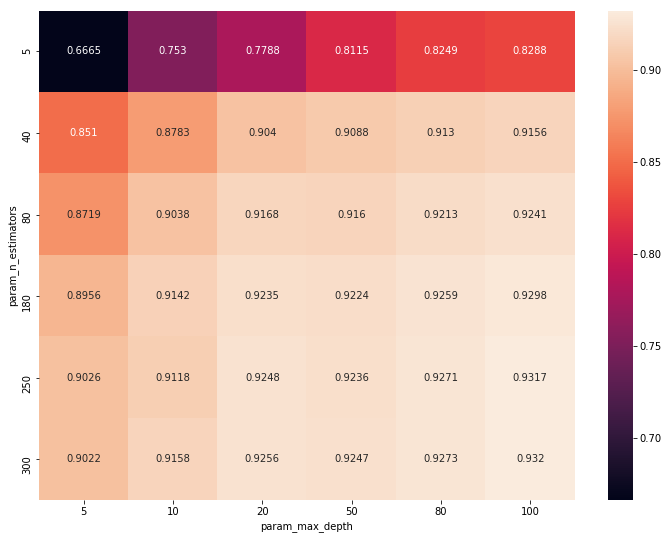

In [60]:
df_gridsearch = pd.DataFrame(gd.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

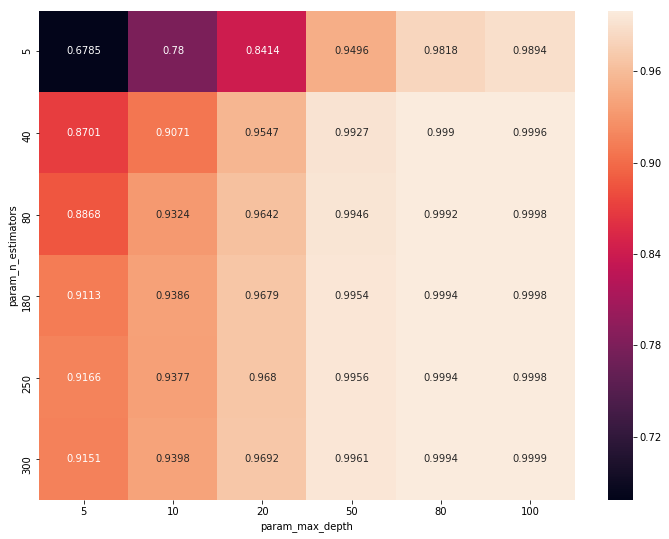

In [62]:
df_gridsearch = pd.DataFrame(gd.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');

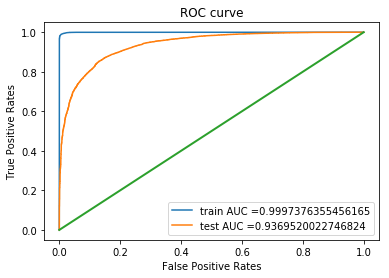

In [64]:
from sklearn.metrics import roc_curve, auc


Rforest1 = RandomForestClassifier(n_estimators=300, max_features='sqrt',max_depth=100, class_weight='balanced',n_jobs=-1)
Rforest1.fit(X_train_BOW, Y1_train)

train_fpr, train_tpr, thresholds = roc_curve(Y1_train, Rforest1.predict_proba(X_train_BOW)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, Rforest1.predict_proba(X_test_BOW)[:,1])
#cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,Rforest1.predict_proba(X_cv_BOW)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
#plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

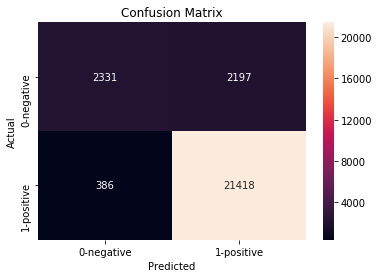

In [68]:
import seaborn as sb
C_b = confusion_matrix(Y1_test,Rforest1.predict(X_test_BOW))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

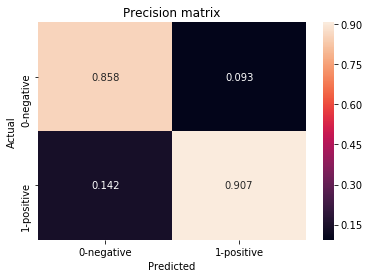

In [69]:
B_b =(C_b/C_b.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

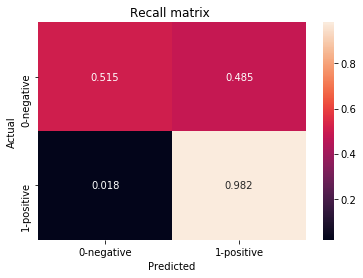

In [70]:
A_b =(((C_b.T)/(C_b.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [71]:
features = Rforest1.feature_importances_
features_sorted = features.argsort()


In [72]:
Best_features = features_sorted[-20:]

In [73]:
print(np.take(count_vect.get_feature_names(), np.asarray(Best_features)))

['would not' 'favorite' 'highly' 'money' 'easy' 'received' 'good'
 'thought' 'worst' 'would' 'not buy' 'perfect' 'loves' 'bad'
 'disappointed' 'delicious' 'love' 'best' 'great' 'not']


In [74]:
bestwords = np.take(count_vect.get_feature_names(), np.asarray(Best_features))

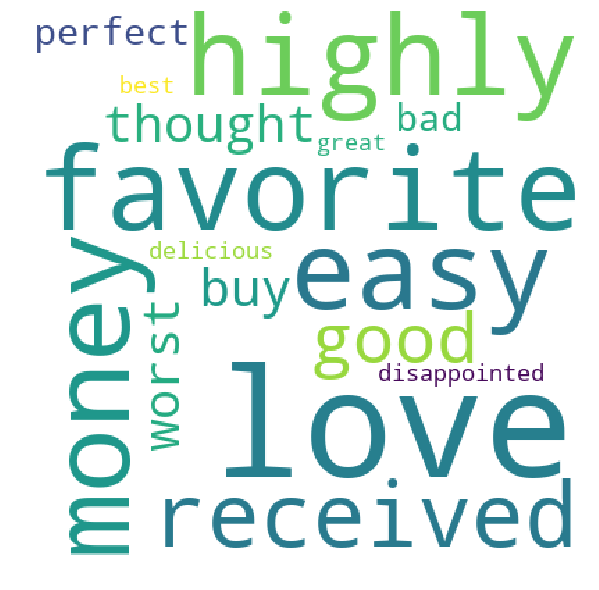

In [78]:
wordcloud = WordCloud(width = 400, height = 400, background_color ='white', min_font_size = 10).generate(' '.join(word for word in bestwords.tolist())) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# [2] TFIDF :

In [79]:
tf_idf_vect = TfidfVectorizer(min_df = 10, ngram_range = (1,2))
tf_idf_vect.fit(X1_train["UPDATEDTEXT"])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X1_train_tfidf = tf_idf_vect.transform(X1_train["UPDATEDTEXT"])
print("the type of count vectorizer ",type(X1_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X1_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X1_train_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'abandon', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 36016)
the number of unique words including both unigrams and bigrams  36016


In [81]:
#X1_cv_tfidf=tf_idf_vect.transform(X1_cv["UPDATEDTEXT"])
#X1_cv_tfidf.shape

In [82]:
X1_test_tfidf=tf_idf_vect.transform(X1_test["UPDATEDTEXT"])
X1_test_tfidf.shape

(26332, 36016)

In [83]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [5,40,80,180,250,300]
depth = [5,10,20,50,80,100]
param_grid = {'n_estimators': n_estimators ,'max_depth': depth}


Rforest2 = RandomForestClassifier(max_features='sqrt',class_weight='balanced')
gd1 = GridSearchCV(Rforest2, param_grid, scoring = 'roc_auc', n_jobs = -1)
gd1.fit(X1_train_tfidf, Y1_train)
print("best parameters :\n",gd1.best_estimator_)


Best_n_estimators= gd1.best_estimator_.n_estimators
print("Best n_estimator is : ",Best_n_estimators)

Best_depth=gd1.best_estimator_.max_depth
print("Best depth is : ",Best_depth)

best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Best n_estimator is :  300
Best depth is :  100
Wall time: 34min 17s


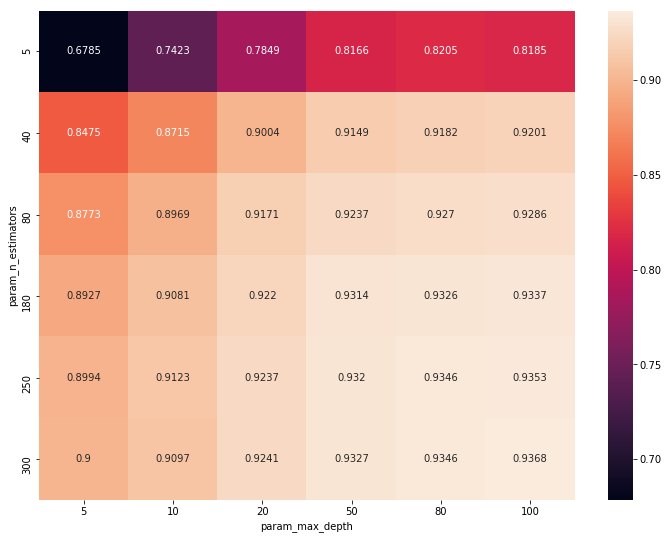

In [84]:
df_gridsearch = pd.DataFrame(gd1.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

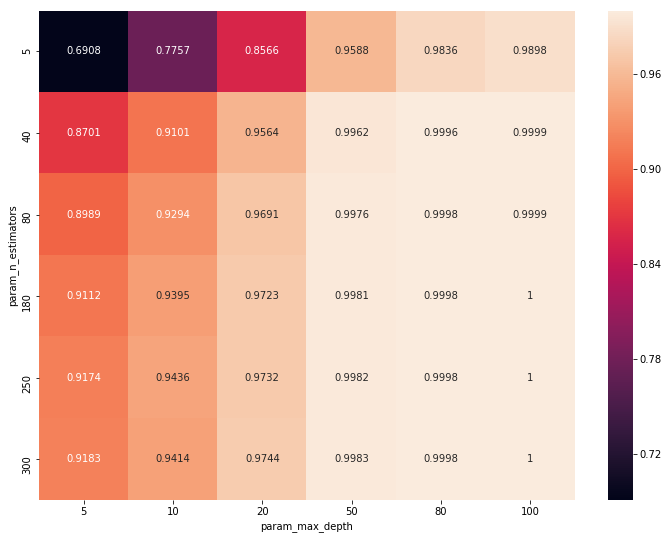

In [85]:
df_gridsearch = pd.DataFrame(gd1.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');

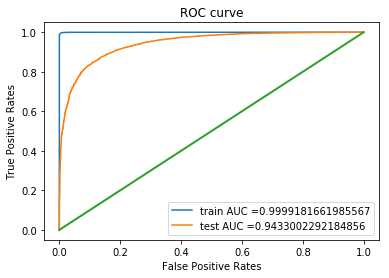

In [88]:
from sklearn.metrics import roc_curve, auc


Rforest3 = RandomForestClassifier(n_estimators=300, max_features='sqrt',max_depth=100, class_weight='balanced',n_jobs=-1)
Rforest3.fit(X1_train_tfidf, Y1_train)

train_fpr, train_tpr, thresholds = roc_curve(Y1_train, Rforest3.predict_proba(X1_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, Rforest3.predict_proba(X1_test_tfidf)[:,1])
#cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,Rforest3.predict_proba(X1_cv_tfidf)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
#plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

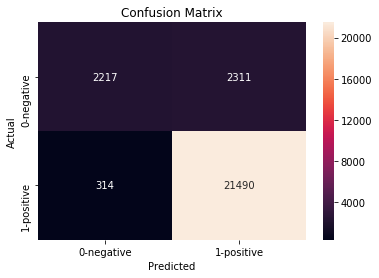

In [89]:
import seaborn as sb
C_t = confusion_matrix(Y1_test,Rforest3.predict(X1_test_tfidf))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

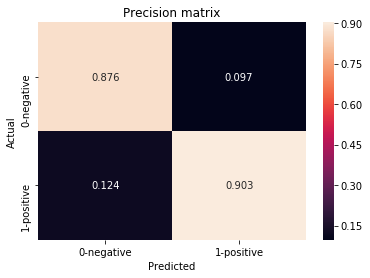

In [90]:
B_t =(C_t/C_t.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_t, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

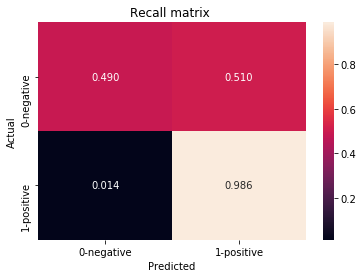

In [91]:
A_t =(((C_t.T)/(C_t.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_t, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [92]:
features1 = Rforest3.feature_importances_
features_sorted1 = features1.argsort()


In [93]:
Best_features1 = features_sorted1[-20:]

In [94]:
print(np.take(tf_idf_vect.get_feature_names(), np.asarray(Best_features1)))

['waste' 'return' 'would not' 'thought' 'highly' 'easy' 'money' 'favorite'
 'would' 'not buy' 'good' 'perfect' 'bad' 'loves' 'disappointed'
 'delicious' 'love' 'best' 'great' 'not']


In [95]:
bestwords1 = np.take(tf_idf_vect.get_feature_names(), np.asarray(Best_features))

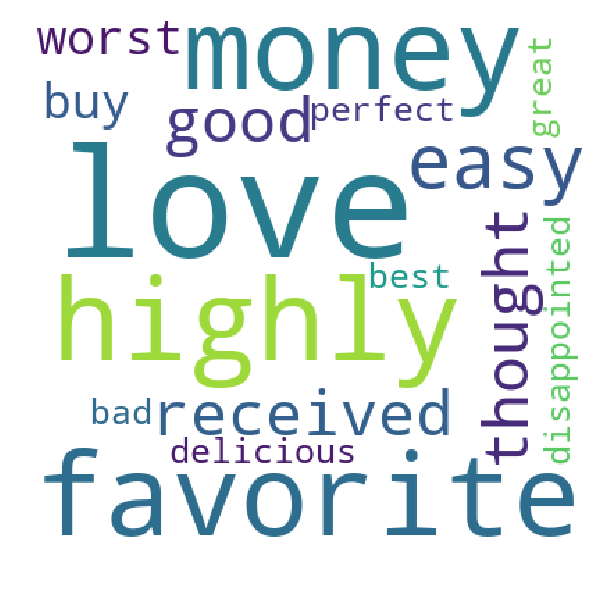

In [96]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 400, height = 400, background_color ='white', min_font_size = 10).generate(' '.join(word for word in bestwords1.tolist())) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# [3] AVG W2V :

In [45]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X1_train["UPDATEDTEXT"]:
    list_of_sentance_train.append(sentance.split())

In [46]:
# Train your own Word2Vec model using your own text corpus
#i=0
#list_of_sentance_cv=[]
#for sentance in X1_cv["UPDATEDTEXT"]:
#    list_of_sentance_cv.append(sentance.split())

In [47]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_test=[]
for sentance in X1_test["UPDATEDTEXT"]:
    list_of_sentance_test.append(sentance.split())

In [48]:
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


[('fantastic', 0.829794704914093), ('good', 0.8250737190246582), ('awesome', 0.8147908449172974), ('terrific', 0.8144586682319641), ('excellent', 0.7951242923736572), ('perfect', 0.7688958048820496), ('wonderful', 0.7417868971824646), ('amazing', 0.7359192371368408), ('nice', 0.6646455526351929), ('decent', 0.654685378074646)]
[('greatest', 0.7378907203674316), ('best', 0.7341185808181763), ('experienced', 0.6787043213844299), ('awful', 0.665831446647644), ('coolest', 0.665432333946228), ('tastiest', 0.6595968008041382), ('disgusting', 0.6263452172279358), ('ive', 0.6118615865707397), ('closest', 0.609734058380127), ('terrible', 0.5996009707450867)]


In [49]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14706
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'buggers', 'success', 'rate', 'day']


In [50]:
# Please write all the code with proper documentation
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 61441/61441 [03:35<00:00, 284.88it/s]


61441
50


In [51]:
# Please write all the code with proper documentation
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [01:42<00:00, 257.90it/s]


26332
50


In [103]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [5,40,80,180,250,300]
depth = [5,10,20,50,80,100]
param_grid = {'n_estimators': n_estimators ,'max_depth': depth}


Rforest4 = RandomForestClassifier(max_features='sqrt',class_weight='balanced')
gd2 = GridSearchCV(Rforest4, param_grid, scoring = 'roc_auc', n_jobs = -1)
gd2.fit(sent_vectors_train, Y1_train)
print("best parameters :\n",gd2.best_estimator_)


Best_n_estimators= gd2.best_estimator_.n_estimators
print("Best n_estimator is : ",Best_n_estimators)

Best_depth=gd2.best_estimator_.max_depth
print("Best depth is : ",Best_depth)

best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=80, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Best n_estimator is :  300
Best depth is :  80
Wall time: 32min 48s


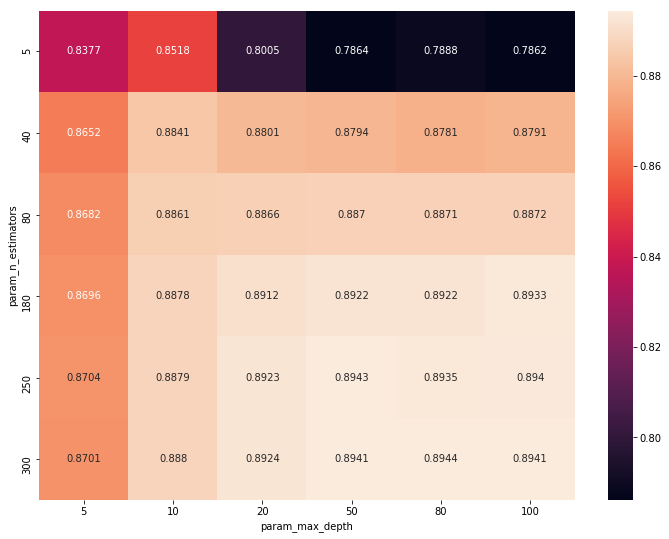

In [104]:
df_gridsearch = pd.DataFrame(gd2.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

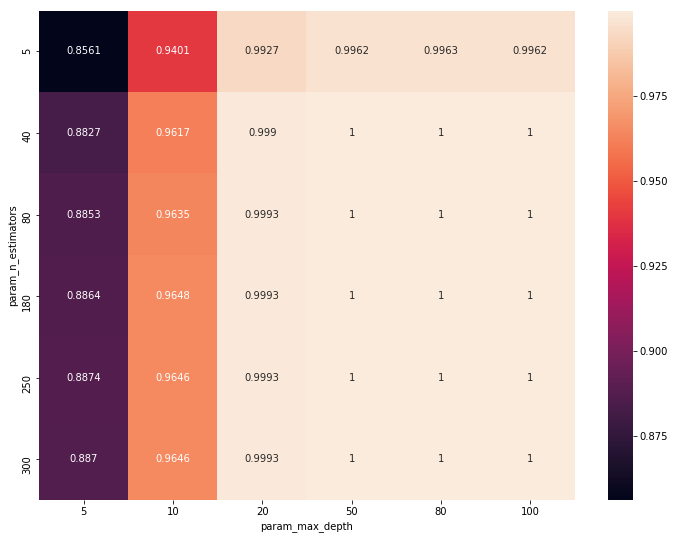

In [105]:
df_gridsearch = pd.DataFrame(gd2.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');

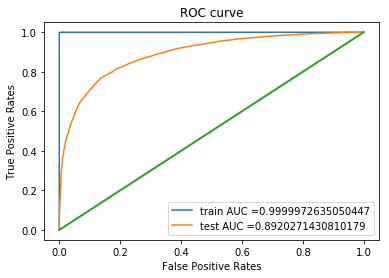

In [112]:
from sklearn.metrics import roc_curve, auc


Rforest5 = RandomForestClassifier(n_estimators=300, max_features='sqrt',max_depth=80, class_weight='balanced',n_jobs=-1)
Rforest5.fit(sent_vectors_train, Y1_train)

train_fpr, train_tpr, thresholds = roc_curve(Y1_train, Rforest5.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, Rforest5.predict_proba(sent_vectors_test)[:,1])
#cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,Rforest5.predict_proba(sent_vectors_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
#plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

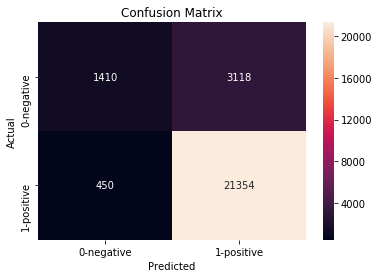

In [113]:
import seaborn as sb
C_a = confusion_matrix(Y1_test,Rforest5.predict(sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_a, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

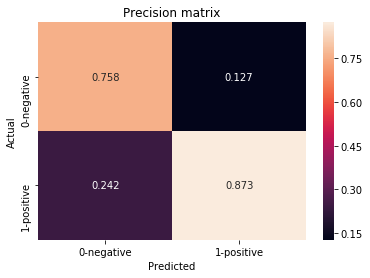

In [114]:
B_a =(C_a/C_a.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_a, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

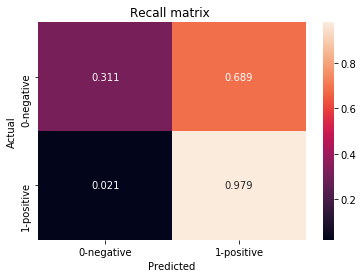

In [115]:
A_a =(((C_a.T)/(C_a.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_a, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# [4] TFIDF weighted W2V :

In [60]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X1_train["UPDATEDTEXT"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [61]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1  

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [42:26<00:00, 24.13it/s]


In [62]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1


100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [19:06<00:00, 22.97it/s]


In [109]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [5,40,80,180,250,300]
depth = [5,10,20,50,80,100]
param_grid = {'n_estimators': n_estimators ,'max_depth': depth}


Rforest6 = RandomForestClassifier(max_features='sqrt',class_weight='balanced')
gd3 = GridSearchCV(Rforest6, param_grid, scoring = 'roc_auc', n_jobs = -1)
gd3.fit(tfidf_sent_vectors_train, Y1_train)
print("best parameters :\n",gd3.best_estimator_)


Best_n_estimators= gd3.best_estimator_.n_estimators
print("Best n_estimator is : ",Best_n_estimators)

Best_depth=gd3.best_estimator_.max_depth
print("Best depth is : ",Best_depth)

best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Best n_estimator is :  300
Best depth is :  50
Wall time: 18min 28s


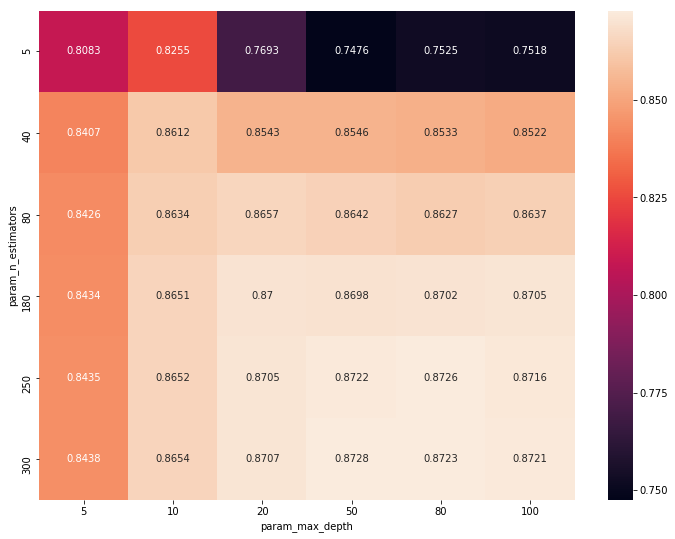

In [110]:
df_gridsearch = pd.DataFrame(gd3.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

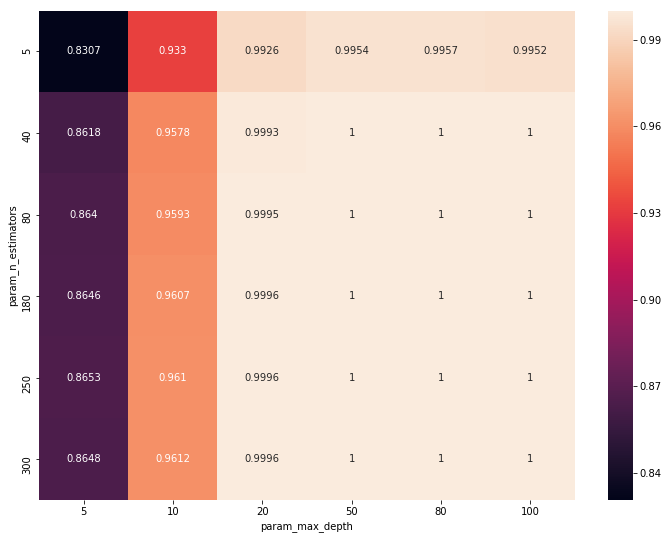

In [111]:
df_gridsearch = pd.DataFrame(gd3.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');

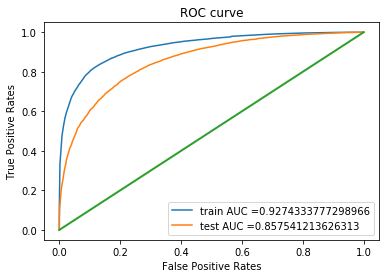

In [124]:
from sklearn.metrics import roc_curve, auc


Rforest7 = RandomForestClassifier(n_estimators=300, max_features='sqrt',max_depth=50, class_weight='balanced',n_jobs=-1)
Rforest7.fit(sent_vectors_train, Y1_train)

train_fpr, train_tpr, thresholds = roc_curve(Y1_train, Rforest7.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, Rforest7.predict_proba(tfidf_sent_vectors_test)[:,1])
#cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,Rforest7.predict_proba(tfidf_sent_vectors_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
#plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

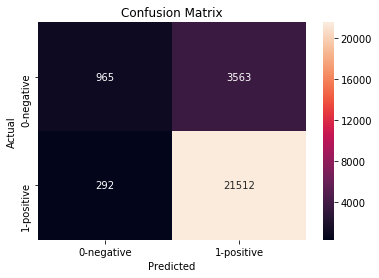

In [125]:
import seaborn as sb
C_ta = confusion_matrix(Y1_test,Rforest7.predict(tfidf_sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_ta, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

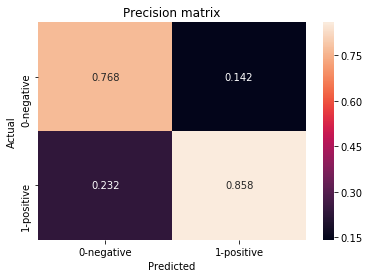

In [126]:
B_ta =(C_ta/C_ta.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_ta, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

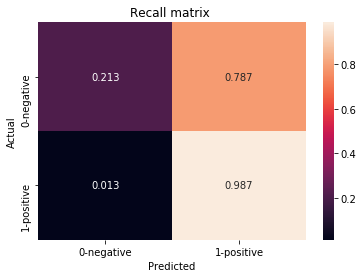

In [127]:
A_ta =(((C_ta.T)/(C_ta.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_ta, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# GBDT --> XGBoost :

# 1] BOW :

In [128]:
%%time
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [5,40,80,180,250,300]
depth = [5,10,20,50,80,100]
param_grid = {'n_estimators': n_estimators ,'max_depth': depth}


Xg=XGBClassifier(class_weight='balanced')
gds= GridSearchCV(Xg, param_grid, scoring = 'roc_auc', n_jobs = -1)
gds.fit(X_train_BOW, Y1_train)
print("best parameters :\n",gds.best_estimator_)


Best_n_estimators= gds.best_estimator_.n_estimators
print("Best n_estimator is : ",Best_n_estimators)

Best_depth=gds.best_estimator_.max_depth
print("Best depth is : ",Best_depth)

best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=50, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
Best n_estimator is :  300
Best depth is :  50
Wall time: 5h 1min 14s


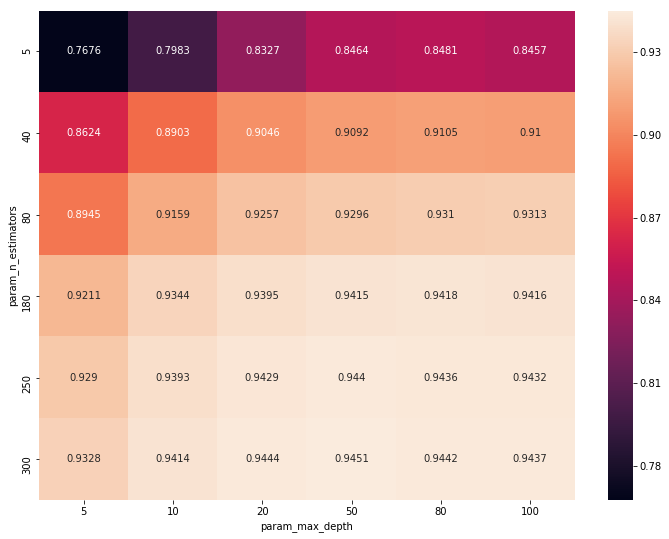

In [129]:
df_gridsearch = pd.DataFrame(gds.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

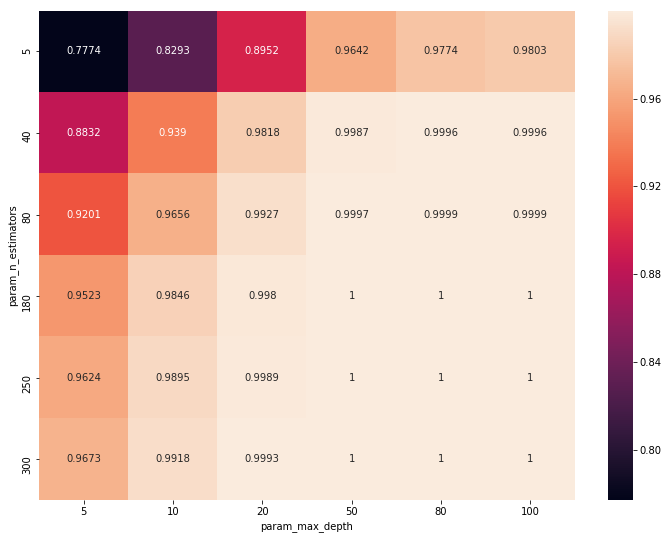

In [130]:
df_gridsearch = pd.DataFrame(gds.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');

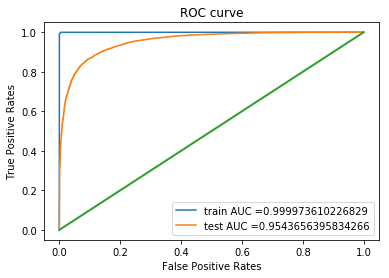

In [132]:
from sklearn.metrics import roc_curve, auc


xgbClassifier = XGBClassifier(n_estimators=300, max_features='sqrt',max_depth=50, class_weight='balanced',n_jobs=-1)
xgbClassifier.fit(X_train_BOW, Y1_train)

train_fpr, train_tpr, thresholds = roc_curve(Y1_train, xgbClassifier.predict_proba(X_train_BOW)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, xgbClassifier.predict_proba(X_test_BOW)[:,1])
#cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,xgbClassifier.predict_proba(X_cv_BOW)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
#plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

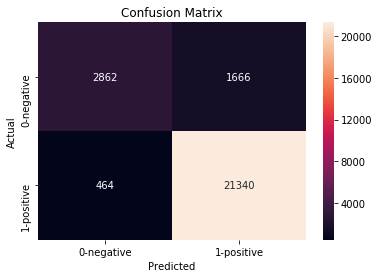

In [133]:
import seaborn as sb
C_b1 = confusion_matrix(Y1_test,xgbClassifier.predict(X_test_BOW))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_b1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

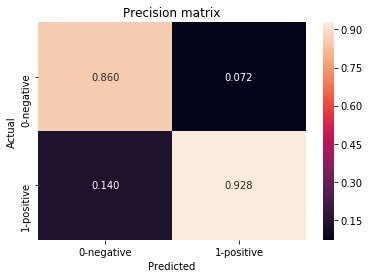

In [134]:
B_b1 =(C_b1/C_b1.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_b1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

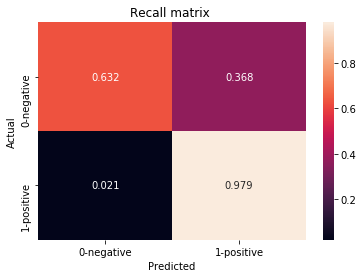

In [135]:
A_b1 =(((C_b1.T)/(C_b1.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_b1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2] TFIDF :

In [136]:
%%time
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [5,40,80,180,250,300]
depth = [5,10,20,50,80,100]
param_grid = {'n_estimators': n_estimators ,'max_depth': depth}


Xg1=XGBClassifier(class_weight='balanced')
gdst= GridSearchCV(Xg, param_grid, scoring = 'roc_auc', n_jobs = -1)
gdst.fit(X1_train_tfidf, Y1_train)
print("best parameters :\n",gdst.best_estimator_)


Best_n_estimators= gdst.best_estimator_.n_estimators
print("Best n_estimator is : ",Best_n_estimators)

Best_depth=gdst.best_estimator_.max_depth
print("Best depth is : ",Best_depth)

best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=20, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
Best n_estimator is :  300
Best depth is :  20
Wall time: 7h 34min 6s


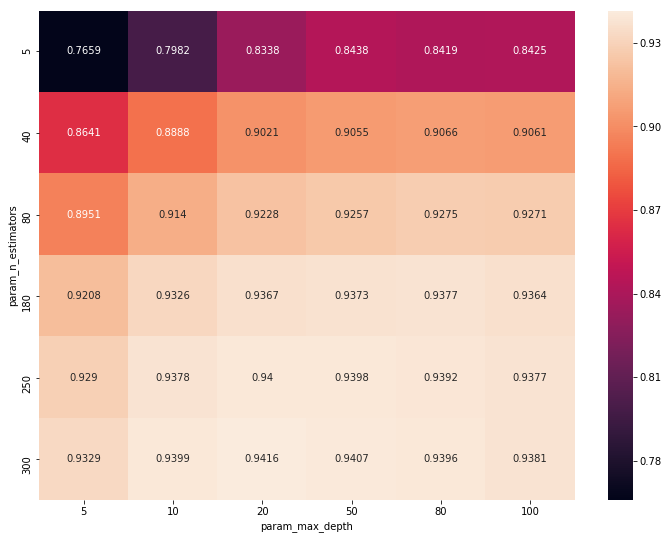

In [137]:
df_gridsearch = pd.DataFrame(gdst.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

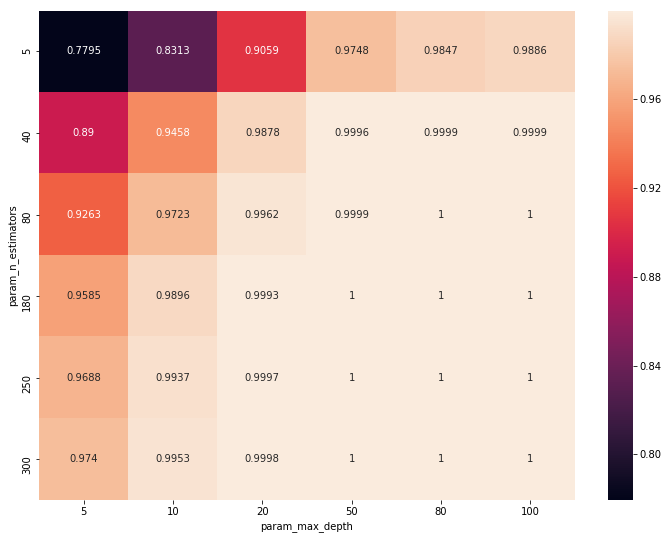

In [138]:
df_gridsearch = pd.DataFrame(gdst.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');

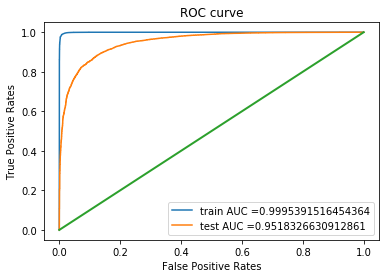

In [139]:
from sklearn.metrics import roc_curve, auc


xgbClassifier1 = XGBClassifier(n_estimators=300, max_features='sqrt',max_depth=20, class_weight='balanced',n_jobs=-1)
xgbClassifier1.fit(X1_train_tfidf, Y1_train)

train_fpr, train_tpr, thresholds = roc_curve(Y1_train, xgbClassifier1.predict_proba(X1_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, xgbClassifier1.predict_proba(X1_test_tfidf)[:,1])
#cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,xgbClassifier1.predict_proba(X1_cv_tfidf)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
#plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

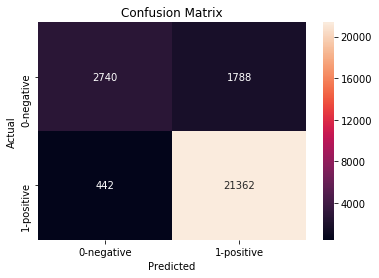

In [140]:
import seaborn as sb
C_t1 = confusion_matrix(Y1_test,xgbClassifier1.predict(X1_test_tfidf))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

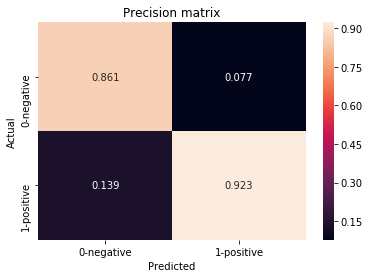

In [141]:
B_t1 =(C_t1/C_t1.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_t1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

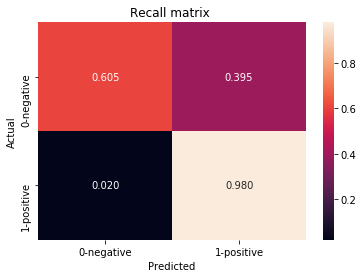

In [142]:
A_t1 =(((C_t1.T)/(C_t1.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_t1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3] AVG W2V :

In [52]:
sent_train=np.array(sent_vectors_train)

In [53]:
%%time
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [5,40,80,180,250,300]
depth = [5,10,20,50,80,100]
param_grid = {'n_estimators': n_estimators ,'max_depth': depth}


Xg1=XGBClassifier(class_weight='balanced')
gdavg= GridSearchCV(Xg1, param_grid, scoring = 'roc_auc', n_jobs = -1)
gdavg.fit(sent_train, Y1_train)
print("best parameters :\n",gdavg.best_estimator_)


Best_n_estimators= gdavg.best_estimator_.n_estimators
print("Best n_estimator is : ",Best_n_estimators)

Best_depth=gdavg.best_estimator_.max_depth
print("Best depth is : ",Best_depth)

best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
Best n_estimator is :  300
Best depth is :  10
Wall time: 1h 46min 48s


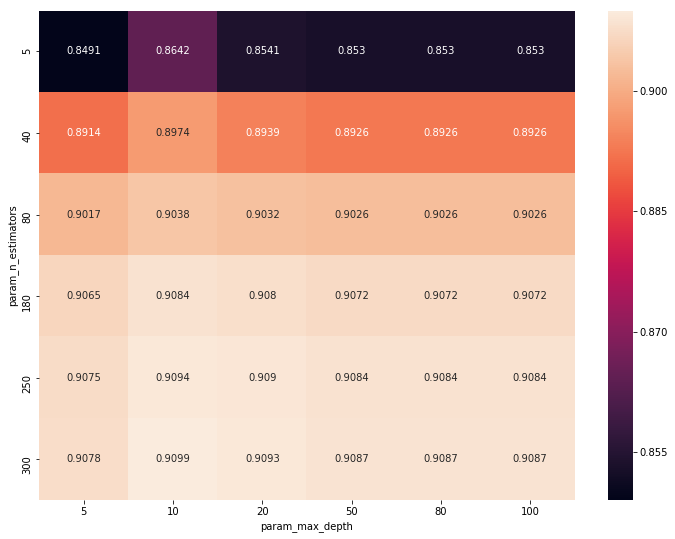

In [54]:
df_gridsearch = pd.DataFrame(gdavg.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

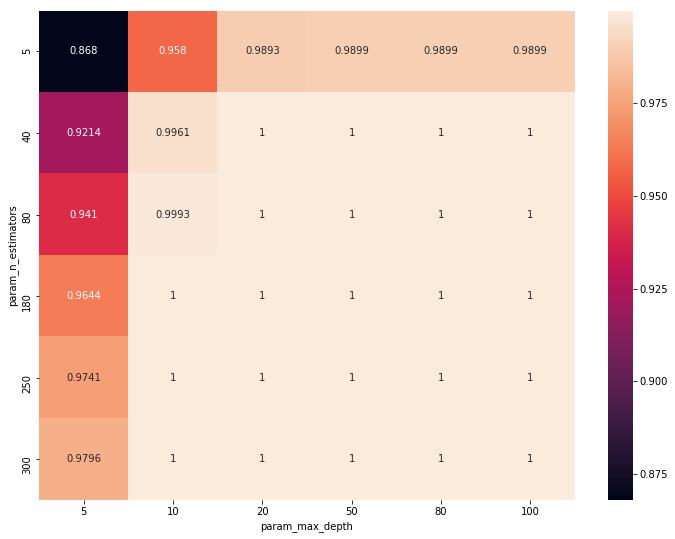

In [55]:
df_gridsearch = pd.DataFrame(gdavg.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');

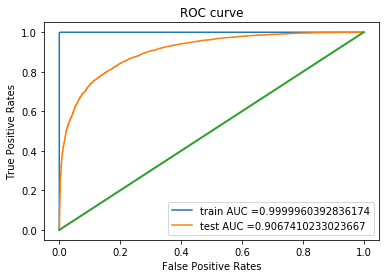

In [56]:
from sklearn.metrics import roc_curve, auc


xgbClassifier2 = XGBClassifier(n_estimators=300, max_features='sqrt',max_depth=10, class_weight='balanced',n_jobs=-1)
xgbClassifier2.fit(sent_train, Y1_train)

train_fpr, train_tpr, thresholds = roc_curve(Y1_train, xgbClassifier2.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, xgbClassifier2.predict_proba(sent_vectors_test)[:,1])
#cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,xgbClassifier2.predict_proba(sent_vectors_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
#plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

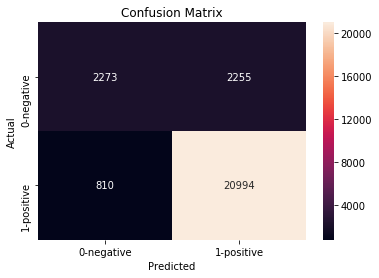

In [57]:
import seaborn as sb
C_avg = confusion_matrix(Y1_test,xgbClassifier2.predict(sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_avg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

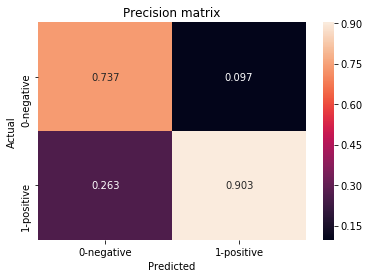

In [58]:
B_avg =(C_avg/C_avg.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_avg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

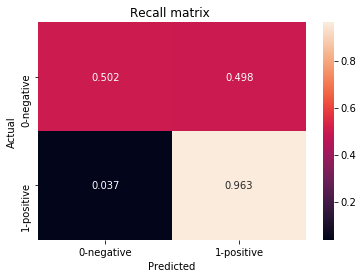

In [59]:
A_avg =(((C_avg.T)/(C_avg.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_avg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4] TFIDF weighted W2V :

In [66]:
tfidf_train=np.array(tfidf_sent_vectors_train)

In [67]:
%%time
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [5,40,80,180,250,300]
depth = [5,10,20,50,80,100]
param_grid = {'n_estimators': n_estimators ,'max_depth': depth}


Xg3=XGBClassifier(class_weight='balanced')
gdsat= GridSearchCV(Xg3, param_grid, scoring = 'roc_auc', n_jobs = -1)
gdsat.fit(tfidf_train, Y1_train)
print("best parameters :\n",gdsat.best_estimator_)


Best_n_estimators= gdsat.best_estimator_.n_estimators
print("Best n_estimator is : ",Best_n_estimators)

Best_depth=gdsat.best_estimator_.max_depth
print("Best depth is : ",Best_depth)

best parameters :
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=50, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
Best n_estimator is :  300
Best depth is :  50
Wall time: 2h 8min 51s


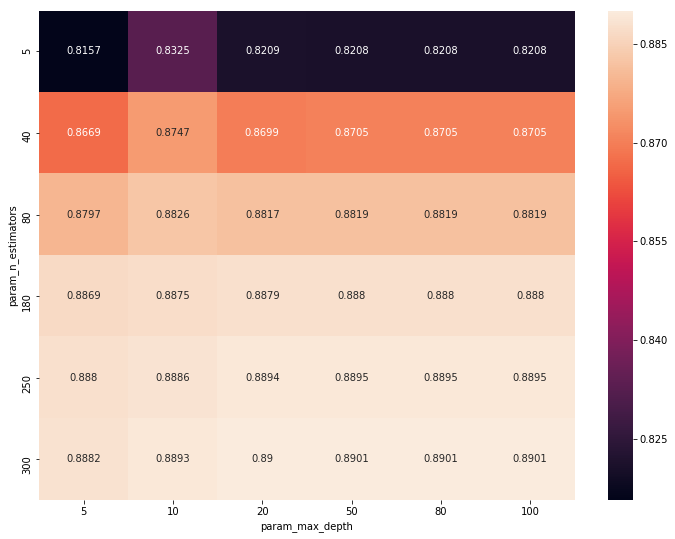

In [68]:
df_gridsearch = pd.DataFrame(gdsat.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

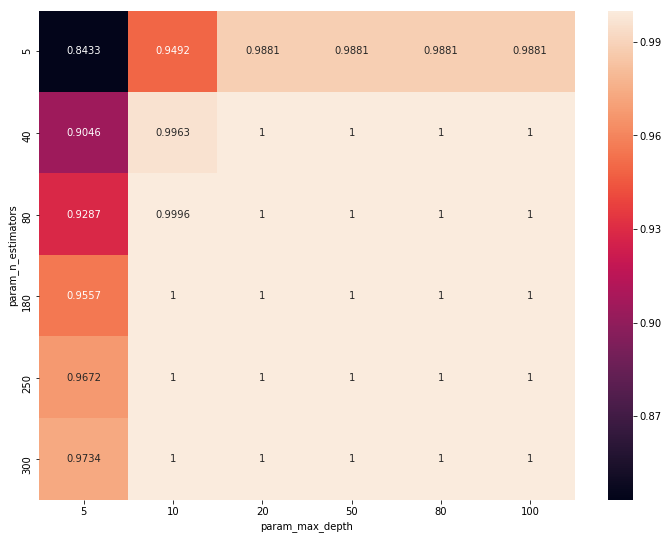

In [69]:
df_gridsearch = pd.DataFrame(gdsat.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(12, 9))

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');

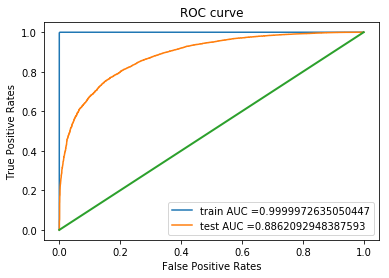

In [70]:
from sklearn.metrics import roc_curve, auc


xgbClassifier4 = XGBClassifier(n_estimators=300, max_features='sqrt',max_depth=50, class_weight='balanced',n_jobs=-1)
xgbClassifier4.fit(tfidf_train, Y1_train)

train_fpr, train_tpr, thresholds = roc_curve(Y1_train, xgbClassifier4.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, xgbClassifier4.predict_proba(tfidf_sent_vectors_test)[:,1])
#cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,xgbClassifier4.predict_proba(tfidf_sent_vectors_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
#plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

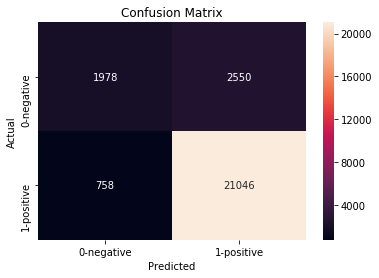

In [71]:
import seaborn as sb
C_tavg = confusion_matrix(Y1_test,xgbClassifier4.predict(tfidf_sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_tavg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

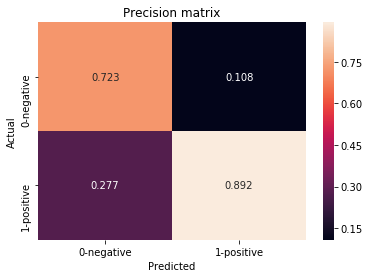

In [72]:
B_tavg =(C_tavg/C_tavg.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_tavg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

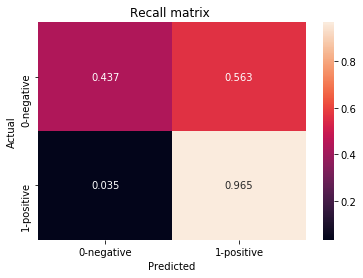

In [73]:
A_tavg =(((C_tavg.T)/(C_tavg.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_tavg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# CONCLUSIONS :

In [83]:
from prettytable import PrettyTable
    
x = PrettyTable(["Vectorizer","Methods", "Best Max Depth","n_estimators","AUC score"])
x.align["Vectorizer"] = "l"
x.add_row(["BOW","Randomforest \nGBDT(XGBoost)\n","100\n50","300\n300","93.695\n95.43"])
x.add_row(["tfidf","Randomforest \nGBDT(XGBoost)\n","100\n20","300\n300","94.33\n95.18"])
x.add_row(["Average w2v","Randomforest \nGBDT(XGBoost)\n","80\n10","300\n300","89.202\n90.67"])
x.add_row(["Tfidf w2v","Randomforest \nGBDT(XGBoost)\n","50\n50","300\n300","85.75\n88.62"])

print(x.get_string(title="RANDOMFOREST AND GBDT ON DIFFERENT FEATURIZATION"))

+-------------------------------------------------------------------------+
|             RANDOMFOREST AND GBDT ON DIFFERENT FEATURIZATION            |
+-------------+---------------+----------------+--------------+-----------+
| Vectorizer  |    Methods    | Best Max Depth | n_estimators | AUC score |
+-------------+---------------+----------------+--------------+-----------+
| BOW         | Randomforest  |      100       |     300      |   93.695  |
|             | GBDT(XGBoost) |       50       |     300      |   95.43   |
|             |               |                |              |           |
| tfidf       | Randomforest  |      100       |     300      |   94.33   |
|             | GBDT(XGBoost) |       20       |     300      |   95.18   |
|             |               |                |              |           |
| Average w2v | Randomforest  |       80       |     300      |   89.202  |
|             | GBDT(XGBoost) |       10       |     300      |   90.67   |
|           

1] XGBoost implementation of GBDT performs better than Randomforest on arious text featurizations.<br>
2] Tfidf and BOW performed the best compared to others.<br>
3] We got the least AUC for Tfidf W2V.<br>